In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df=pd.read_excel('/content/Airlines+Data.xlsx')

In [3]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
df1=df.copy()

In [5]:
def format_date(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime("%b-%y")

In [6]:
df['Formatted_Date']=df['Month'].apply(format_date)

In [7]:
df

,Month,Passengers,Formatted_Date
0,1995-01-01,112,Jan-95
1,1995-02-01,118,Feb-95
2,1995-03-01,132,Mar-95
3,1995-04-01,129,Apr-95
4,1995-05-01,121,May-95
...,...,...,...
91,2002-08-01,405,Aug-02
92,2002-09-01,355,Sep-02
93,2002-10-01,306,Oct-02
94,2002-11-01,271,Nov-02


In [8]:
df['Year'] = df['Formatted_Date'].str.split('-').str[1]
df['M'] = df['Formatted_Date'].str.split('-').str[0]

In [9]:
df

,Month,Passengers,Formatted_Date,Year,M
0,1995-01-01,112,Jan-95,95,Jan
1,1995-02-01,118,Feb-95,95,Feb
2,1995-03-01,132,Mar-95,95,Mar
3,1995-04-01,129,Apr-95,95,Apr
4,1995-05-01,121,May-95,95,May
...,...,...,...,...,...
91,2002-08-01,405,Aug-02,02,Aug
92,2002-09-01,355,Sep-02,02,Sep
93,2002-10-01,306,Oct-02,02,Oct
94,2002-11-01,271,Nov-02,02,Nov


In [10]:
df = pd.get_dummies(df, columns=['M'])

In [11]:
df['t'] = range(1, len(df) + 1)

In [12]:
df['t_square']=df['t']**2

In [13]:
df['Log_Passengers'] = np.log(df['Passengers'])

In [14]:
df

,Month,Passengers,Formatted_Date,Year,M_Apr,M_Aug,M_Dec,M_Feb,M_Jan,M_Jul,M_Jun,M_Mar,M_May,M_Nov,M_Oct,M_Sep,t,t_square,Log_Passengers
0,1995-01-01,112,Jan-95,95,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb-95,95,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar-95,95,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr-95,95,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May-95,95,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug-02,02,0,1,0,0,0,0,0,0,0,0,0,0,92,8464,6.003887
92,2002-09-01,355,Sep-02,02,0,0,0,0,0,0,0,0,0,0,0,1,93,8649,5.872118
93,2002-10-01,306,Oct-02,02,0,0,0,0,0,0,0,0,0,0,1,0,94,8836,5.723585
94,2002-11-01,271,Nov-02,02,0,0,0,0,0,0,0,0,0,1,0,0,95,9025,5.602119


splitting the data

In [15]:
Train=df.head(76)
Test=df.tail(20)

checking various Models

In [16]:
#Linear Model

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

57.000147882565884

In [17]:
#Exponential

Exp = smf.ols('Log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.62154394719378

In [18]:
#Quadratic

Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

58.494274639475286

In [19]:
#Additive seasonality

add_sea = smf.ols('Passengers~M_Apr+M_Aug+M_Dec+M_Feb+M_Jan+M_Jul+M_Jun+M_Mar+M_May+M_Nov+M_Oct+M_Sep',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.25413439949477

In [20]:
#Additive Seasonality Quadratic

add_sea_Quad = smf.ols('Passengers~t+t_square+M_Apr+M_Aug+M_Dec+M_Feb+M_Jan+M_Jul+M_Jun+M_Mar+M_May+M_Nov+M_Oct+M_Sep',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

39.75976633806404

In [21]:
#Multiplicative Seasonality

Mul_sea = smf.ols('Log_Passengers~M_Apr+M_Aug+M_Dec+M_Feb+M_Jan+M_Jul+M_Jun+M_Mar+M_May+M_Nov+M_Oct+M_Sep',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

137.61090856256482

In [22]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('Log_Passengers~t+M_Apr+M_Aug+M_Dec+M_Feb+M_Jan+M_Jul+M_Jun+M_Mar+M_May+M_Nov+M_Oct+M_Sep',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

11.784250178871503

In [23]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,11.784250
4,rmse_add_sea_quad,39.759766
1,rmse_Exp,46.621544
0,rmse_linear,57.000148
2,rmse_Quad,58.494275
3,rmse_add_sea,132.254134
5,rmse_Mult_sea,137.610909


As we can see that the mulitiplicative additive seasonality is having the low rmse value so that we will this model for prediction

we have created dummies for the month column and also created the t ,t square and log_passengers columns.

In [24]:
Mul_Add_sea = smf.ols('Log_Passengers~t+M_Apr+M_Aug+M_Dec+M_Feb+M_Jan+M_Jul+M_Jun+M_Mar+M_May+M_Nov+M_Oct+M_Sep',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))

smoothenig techniques

Time Series Decomposition plot

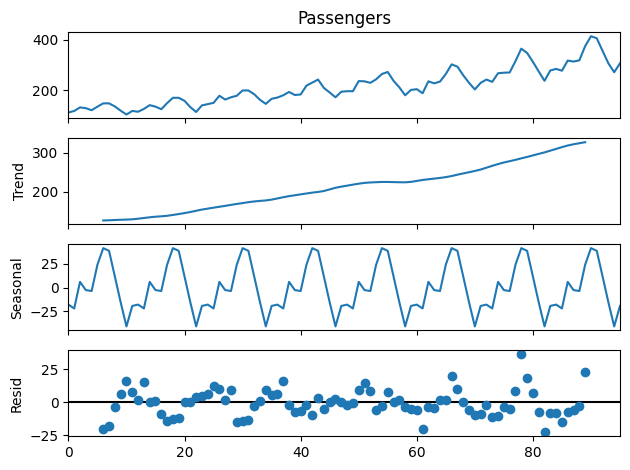

In [28]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

ACF and PACF plots

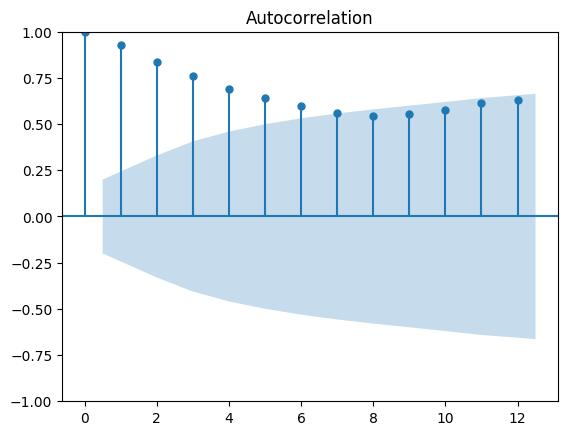

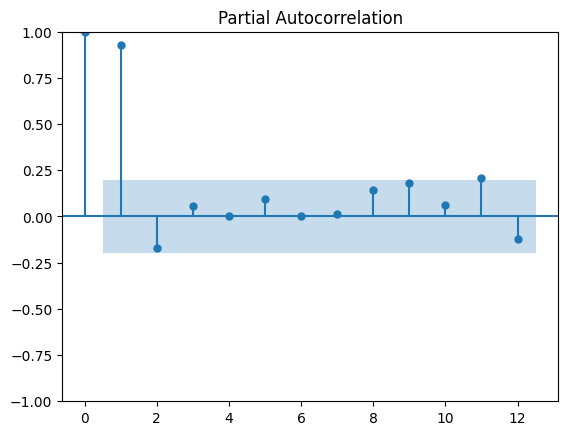

In [29]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=12)
tsa_plots.plot_pacf(df.Passengers,lags=12)
plt.show()

In [30]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

Simple Exponential Method

In [32]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


20.42662222246686

Holt method

In [33]:
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_trend=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


12.9628691830974

Holts winter exponential smoothing with additive seasonality and additive trend

In [44]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers)

8.724206745976666

Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [36]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

9.375576393235455

We can see that Holts winter exponential smoothing with additive seasonality and additive trend has low mape value so we can go with that technique

Arima

In [38]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00


In [39]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [41]:
stepwise_fit = auto_arima(df['Passengers'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=619.334, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=622.012, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.965, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.628, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=618.192, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=617.814, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.881, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=616.531, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=618.221, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=617.862, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.462, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.076, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=619.394, Time=0.39 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -304.983
Date:                            Wed, 08 Nov 2023   AIC                            615.965
Time:                                    13:33:48   BIC                            623.222
Sample:                                         0   HQIC                           618.881
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2250      0.099     -2.276      0.023      -0.419      -0.031
ar.S.L12      -0.2274      0.089     -2.548      0.011      -0.402      -0.052
sigma2        90.2700     14.667      6.155      0.000      61.524     119.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.97   Prob(JB):                         0.33
Heteroskedasticity (H):               1.77   Skew:                             0.39
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(Train['Passengers'],
                order = (1, 1,0),
                seasonal_order =(1, 1,0, 12))

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -229.085
Date:                            Wed, 08 Nov 2023   AIC                            464.170
Time:                                    13:35:08   BIC                            470.599
Sample:                                         0   HQIC                           466.698
                                             - 76                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2966      0.115     -2.575      0.010      -0.522      -0.071
ar.S.L12      -0.4435      0.118     -3.759      0.000      -0.675      -0.212
sigma2        80.7603     14.265      5.661      0.000      52.801     108.720
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.99   Prob(JB):                         0.56
Heteroskedasticity (H):               2.27   Skew:                             0.33
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

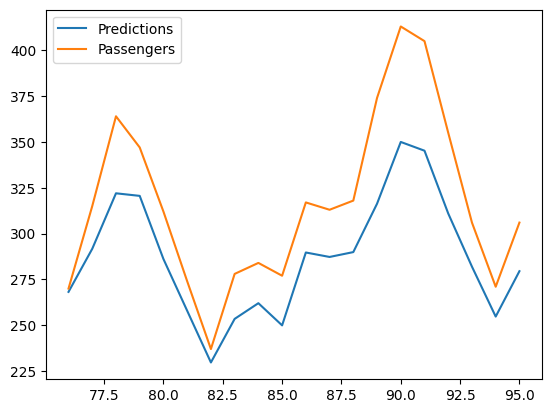

In [43]:
start = len(Train)
end = len(Train) + len(Test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

# plot predictions and actual values
predictions.plot(legend = True)
Test['Passengers'].plot(legend = True)